In [1]:
### import packages ###
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import fsps     # governs the fundamental stellar population synthesis models
# import sedpy    # contains some routines for computing projecting spectra onto filter bandpasses

from scipy.io import readsav

from PIL import Image
import requests

from astropy.io import fits
import astropy as ap
from astropy.cosmology import WMAP9

import astropy.coordinates as coord
from astroquery.sdss import SDSS

sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling

import emcee
import dynesty

from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot

from build_model_funct import build_model
from build_obs_funct import build_obs
from FracSFH_ import FracSFH

from prospect.fitting import fit_model
from prospect.io import write_results as writer

### re-defining plotting defaults ###
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})

%matplotlib inline

### package versions ###
# vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
# print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

In [2]:
start_time = time.time()

In [3]:
### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26

### My Unit Functions ###
def mJy_to_maggies(mJy):
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

In [4]:
### Import full galaxy file (58 galaxies) ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

In [5]:
### Choose a galaxy (0 to 57) ###
# Explorer Path = C:\Users\emma_d\ASTR_Research\Galaxy_output\G0

galaxy_num = 33
Template_Type = 'alpha_agn'

if not os.path.exists('Galaxy_output/G{}/'.format(galaxy_num)):
    os.mkdir('Galaxy_output/G{}/'.format(galaxy_num))
Galaxy_Path = 'Galaxy_output/G{}/'.format(galaxy_num)

print('This is for Galaxy ', galaxy_num + 1)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)
print('The template type is', Template_Type)

This is for Galaxy  34
The Date is 21Jun21
The template type is alpha_agn


In [6]:
# Query SDSS to get optical spectra data
#   Used tutorial from 
#       https://learn.astropy.org/rst-tutorials/User-Defined-Model.html 
#       http://astroweb.case.edu/jakub/TA/Interpolation.html 

Gal_RA, Gal_DEC = AGN_data[galaxy_num][2], AGN_data[galaxy_num][3]
pos = coord.SkyCoord(Gal_RA, Gal_DEC, unit='deg',frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
xid

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


<Table length=1>
       ra             dec               objid        ... run2d instrument
    float64         float64             int64        ... int64   bytes4  
--------------- ---------------- ------------------- ... ----- ----------
169.78179862573 58.0539723805796 1237658302207426603 ...    26       SDSS

In [7]:
### Redshift ###
G_Redshift = xid['z'][0]                                        # Use redshift from SDSS query

cosmo = ap.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)              # cosmological redshift object
ldist_Mpc_units = cosmo.comoving_distance(G_Redshift)           # cosmological redshift

ldist_Mpc = ldist_Mpc_units.value                               # Get ldist in Mpc from ldist with units
tage_of_univ = WMAP9.age(G_Redshift).value                      # age of the universe in Gyr

In [8]:
### Get optical spectrum from SDSS query ###
optical_spectrum = SDSS.get_spectra(plate= xid['plate'][0], fiberID= xid['fiberID'][0], mjd= xid['mjd'][0])[0] 

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


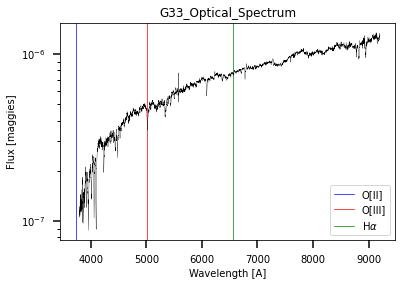

In [9]:
### Plot optical spectrum ###
optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

# Spectra lines for OII, OIII, Halpha
optical_spectrum_lines = optical_spectrum[3].data
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n])
plt.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
plt.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

# Find what units the data is in
units_flux = optical_spectrum[0].header['bunit']
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

# Convert SDSS units to Prospector units
optical_spectrum_flux = f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux)

# Plot the spectra
plot(optical_spectrum_lam, optical_spectrum_flux, color='k', linewidth=.3)
xlabel('Wavelength [A]')
ylabel('Flux [maggies]')
title('G{0}_Optical_Spectrum'.format(galaxy_num))
yscale('log')
legend()

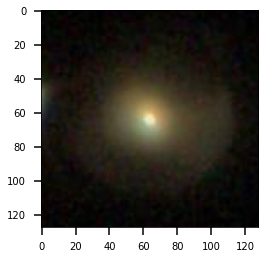

In [10]:
### Get optical image from the url using galaxy RA and DEC ###
SDSS_URL = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra={0}&dec={1}'.format(Gal_RA, Gal_DEC)

SDSS_Image = Image.open(requests.get(SDSS_URL, stream=True).raw)
imshow(SDSS_Image)

In [11]:
### From Dr. Smercina ###
ea_struct = readsav('Data/ea_struct_v9.sav')['ea_struct']
# ea_struct.dtype.names                                     # Keys in ea_struct

There is Spitzer IRS spectrum data for this galaxy
This is galaxy S07 33


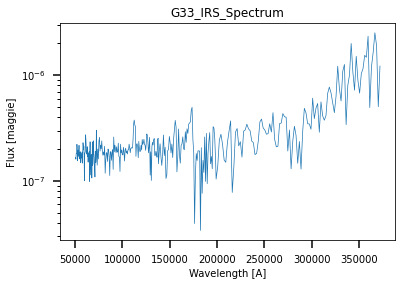

In [12]:
gal_EA_Desig = AGN_data[galaxy_num][1][2:]
s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')       # Pulls only spitzer from sources
ea_struct = ea_struct[s1]                                       # Masks ea_struct to get spitzer galaxies

# If the IRS data contains the galaxy, graph the IRS data. If not print there is no IRS data.
if gal_EA_Desig in ea_struct['EA_DESIG'].astype(str):
    IRS_indicator = 1                                           # Indicates there is IRS data
    print('There is Spitzer IRS spectrum data for this galaxy')
    s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)

    # Convert Smercina units (mu*m,nu*f_nu) to prospector units (A, maggies)
    IRS_wavelength = ea_struct[s][0].irs_spectrum.wave * 10000
    IRS_flux = mJy_to_maggies(10**13 *(ea_struct[s][0].irs_spectrum.wave/(2.998*10**14)) * ea_struct[s][0].irs_spectrum.flux)

    # Masks where IRS_FLUX is very low (~= 0)
    IRS_wavelength =IRS_wavelength[ IRS_flux > 10**-9 ]
    IRS_flux = IRS_flux[ IRS_flux > 10**-9 ]

    # Plot IRS data
    plot(IRS_wavelength, IRS_flux)
    xlabel('Wavelength [A]')
    ylabel('Flux [maggie]')
    title('G{0}_IRS_Spectrum'.format(galaxy_num))
    yscale('log')

else:
    IRS_indicator = 0                                           # Indicates there is no IRS data
    print('There is no Spitzer IRS spectrum data for this galaxy')

print('This is galaxy', gal_EA_Desig, galaxy_num)

In [13]:
### Create run_params dictionary ###
run_params = { 'ldist': ldist_Mpc,
                'agelims': [0.0,8.0,8.5,9.0,9.5,9.8,10.0],
                'object_redshift': G_Redshift,
                'zcontinuous': 1,                           # Leja: 2
                'verbose': False,                           # Lega: True
                'dynesty': False,                           # Change in code
                'emcee': False,                             # Change in code
                'optimize': False,                          # Change in code
                'optimization': False,
                'min_method': 'lm',                     #'lm',
                'nmin': 5,                                  # initially 2, can try 1
                'nwalkers': 128,                            # Leja: 620
                'niter': 512,                               # Leja: 7500
                'nburn': [16, 32, 64],                      # Leja: [150, 200, 200]
                'optimization': False,
                'nested_method': 'rwalk',
                'nlive_init': 400,
                'nlive_batch': 200,
                'nested_dlogz_init': 0.05,
                'nested_posterior_thresh': 0.05,
                'nested_maxcall': int(1e7),

                # From Leja:
                'objname': 'G{0}_{1}'.format(galaxy_num, Template_Type),
                'initial_disp': 0.1,

                'AGN_switch': True,
                'tage_of_univ': tage_of_univ,
                'Template_Type': Template_Type,
                'galaxy_num': galaxy_num,
                'IRS_indicator': IRS_indicator,
                'SDSS_Query': xid

                # 'nofork': True,
                # 'ftol': 0.5e-5
                # 'maxfev': 5000,
                # 'interval': 0.2,
                # 'convergence_check_interval': 50,
                # 'convergence_chunks': 325,
                # 'convergence_kl_threshold': 0.016,
                # 'convergence_stable_points_criteria': 8, 
                # 'convergence_nhist': 50,
                # 'compute_vega_mags': False,
                # 'interp_type': 'logarithmic',
                }

In [14]:
### Built obs dict using meta-params ###
obs = build_obs(**run_params)

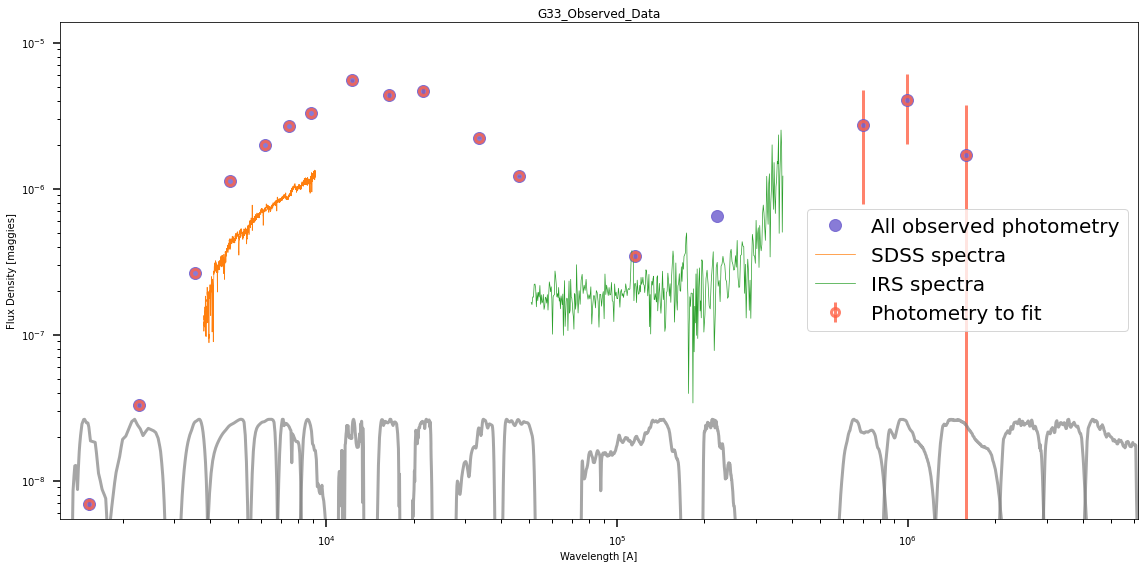

In [15]:
### Plot all observed data ###
wphot = obs["phot_wave"]
mask = obs["phot_mask"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"][mask].min()*0.8, obs["maggies"][mask].max()/0.4  
figure(figsize=(16,8))

# Plot all observed photometry
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# Overplot only data we want to fit (using phot_mask)
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# Plot filter bands
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
title('G{0}_Observed_Data'.format(galaxy_num))
tight_layout()

In [16]:
# Use PolySpec model to match mismatched photometry/spectroscopy:
#       https://github.com/bd-j/prospector/issues/213

In [17]:
### Define agelimits, tilde_alpha, and z_fraction_init for build_model ###
agelims = run_params['agelims']
agelims[-1] = np.log10(tage_of_univ * 1e9)
agebins = np.array([agelims[:-1], agelims[1:]])
ncomp = agebins.shape[1]                              #- 1 Had to modify for array sizes to fit

tilde_alpha = np.array([ncomp - i for i in list(range(1, ncomp))])
z_fraction_init = np.array([(i-1)/float(i) for i in range(ncomp,1,-1)])

run_params['ncomp'] = ncomp
run_params['agebins_init'] = agebins.T
run_params['tilde_alpha'] = tilde_alpha
run_params['z_fraction_init'] = z_fraction_init

In [18]:
### Build model and view model ###
model = build_model(**run_params)

run_params['num_free_params'] = len(model.free_params)
run_params['free_params'] = model.free_params 
run_params['num_data_points'] = len(obs['maggies'][obs["phot_mask"]])

In [19]:
def build_sps(zcontinuous=1, **extras):
    # from prospect.sources.ssp_basis import FastStepBasis
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

In [20]:
sps = build_sps(**run_params)

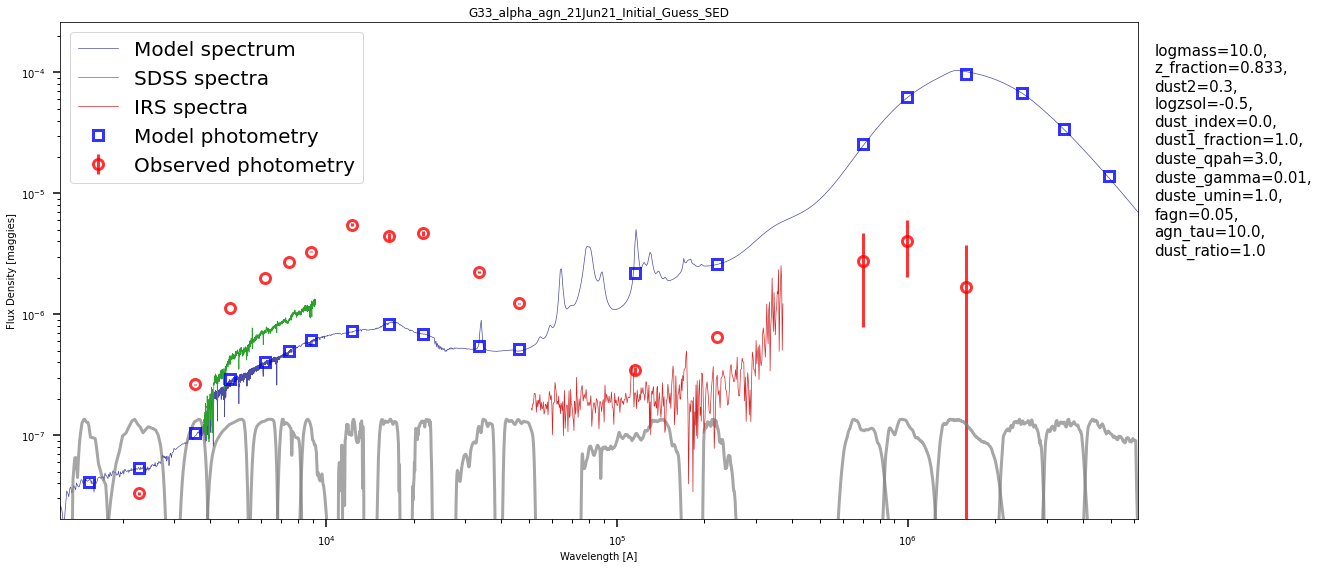

In [21]:
### View Model ###
### prediction for the data from any set of model params

### Generate the model SED at the initial value of theta ###
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["\n{}={:.3}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
wphot = obs["phot_wave"]    # photometric effective wavelengths
if obs["wavelength"] is None:
    # spectroscopic wavelengths
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a                                          # redshift them
else:
    wspec = obs["wavelength"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)


figtext(1.005, .55, title_text, ha="left", fontsize=15)
title('G{0}_{1}_{2}_Initial_Guess_SED'.format(galaxy_num, Template_Type, ts))

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

savefig(Galaxy_Path + 'G{0}_{1}_{2}_Initial_Guess_SED_2'.format(galaxy_num, Template_Type, ts))

In [22]:
### Likelyhood Function ###
"""
For nested sampling lnprobfn(theta, nested=True) will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling lnprobfn(theta, nested=False) returns the posterior probability.
"""

run_params['AGN_switch'] = False


### Running Prospector ###
# Fit the model using chi squared minimization
# Ensemble MCMC sampler around best location from the minimization 
# Dynamic nested sampling with dynesty

# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to know which stellar isochrone and spectral library
# print(sps.ssp.libraries)
# help(fit_model)

In [23]:
from prospect.models.templates import TemplateLibrary

TemplateLibrary.describe("alpha")

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  z_fraction: <class 'prospect.models.priors.Beta'>(mini=0.0,maxi=1.0,alpha=[5 4 3 2 1],beta=[1 1 1 1 1])
  total_mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=25)
  duste_qpah: <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=7.0)
  duste_gamma: <class 'prospect.models.priors.LogUniform'>(mini=0.001,maxi=0.15)
  fagn: <class 'prospect.models.priors.LogUniform'>(mini=1e-05,maxi=3.0)
  agn_tau: <class 'prospect.models.priors.LogUniform'>(mini=5.0,maxi=150.0)
  dust_ratio: <class 'prospect.models.priors.ClippedNormal'>(mean=1.0,sigma=0.3,mini=0.0,maxi=2.0)
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-2.0,maxi=0.5)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred

In [24]:
### Minimization ###
# Uses Levenberg-Marquardt, needed parameters in run_params
# requires a likelihood function that returns a vector of chi values
# imported lnprobfn function takes care of chi values to likelyhood

# --- start minimization ---- # 
run_params["emcee"] = False
run_params["optimize"] = True

print(len(model.free_params))

# if is_free_params < mask_len_array or is_free_params != mask_len_array:
    # print('lm Minimization can be done', '\nlength of free parameters =', is_free_params, '\nlength of data points = ', mask_len_array)
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print("Done optmization in {}s".format(output["optimization"][1]))
# else:
#     print('lm Minimization cannot be perfomed because number of data points is <= number of free parameters', '\nlength of free parameters =', is_free_params, '\nlength of data points = ', mask_len_array)

12
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
Done optmization in 213.6448426246643s


In [25]:
run_params['AGN_switch'] = True

obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

model.theta [10.          0.83333333  0.8         0.75        0.66666667  0.5
  0.3        -0.5         0.          1.          3.          0.01
  1.          0.05       10.          1.        ]
ind_best =  0
theta_best =  [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e-04  5.00000000e+00  1.00000000e+00]


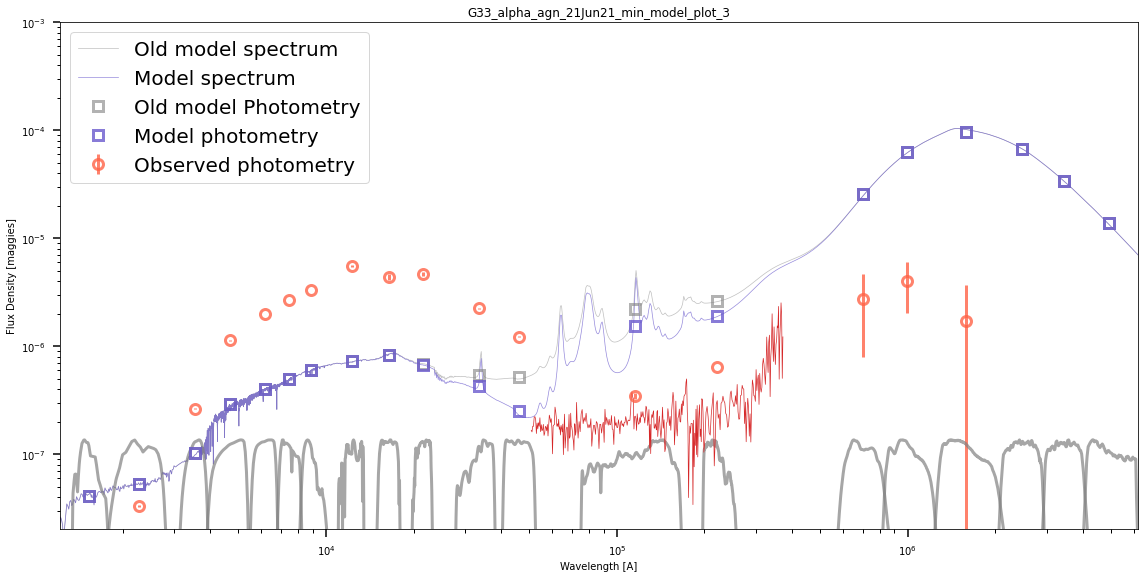

In [26]:
# if is_free_params < mask_len_array or is_free_params != mask_len_array:
print("model.theta", model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print("ind_best = ", ind_best)
theta_best = results[ind_best].x.copy()
print("theta_best = ", theta_best)


# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))


# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
        lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
        marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
        markerfacecolor='none', markeredgecolor='gray', 
        markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
        lw=0.7, color='slateblue', alpha=0.7) 
errorbar(wphot, pphot, label='Model photometry', 
        marker='s', markersize=10, alpha=0.8, ls='', lw=3,
        markerfacecolor='none', markeredgecolor='slateblue', 
        markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
        label='Observed photometry', 
        marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
        ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
        markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ymax = 10**-3
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

plt.plot(optical_spectrum_lam, f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux), color='k', linewidth=.3)

if IRS_indicator == 1:
    plt.plot(IRS_wavelength, IRS_flux)
    title('G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))
    savefig(Galaxy_Path + 'G{0}_{1}_{2}_min_model_plot_3'.format(galaxy_num, Template_Type, ts))
# else:
#     print('The prediction cannot be done because minimization was not performed')

In [27]:
run_params["optimize"] = False
run_params["emcee"] = True

In [28]:
output = fit_model(obs, model, sps, lnprobfn=prospect.fitting.lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)
done emcee in 1793.1022329330444s


In [29]:
ts = time.strftime("%y%b%d", time.localtime())
hfile = Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts)
obs, model, sps = build_obs(**run_params),  build_model(**run_params), build_sps(**run_params) #, build_all(**run_params)

In [30]:
### Use to save results to disk ###
writer.write_hdf5(hfile, run_params, model, obs, 
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1],
                  sps=sps)
                  # Just added in SPS for obtaining result['bestfit']

print('Finished')

/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize run_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
Finished


In [31]:
import prospect.io.read_results as reader
results_type = "emcee" 
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`

# change to file that was just generated
result, obs, __ = reader.results_from(Galaxy_Path + 'G{0}_{1}_{2}_mcmc.h5'.format(galaxy_num, Template_Type, ts), dangerous=False)

In [32]:
# result

In [33]:
def get_best_v2(res, **kwargs):
    """Get the maximum a posteriori parameters.
    """
    imax = np.argmax(res['lnprobability'])
    # there must be a more elegant way to deal with differnt shapes
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta_best = res['chain'][i, j, :].copy()
    except(ValueError):
        theta_best = res['chain'][imax, :].copy()
        
    return  theta_best

In [34]:
## Added from github issue ##

from prospect.utils.plotting import get_best
theta_map = get_best_v2(result)
theta_labels = result['theta_labels']

print(theta_map)
print(result['theta_labels'])

[ 1.09232059e+01  9.99395319e-01  9.95420973e-01  8.57066214e-01
  8.49134781e-01  5.74566651e-01  5.04633342e-03 -1.57209802e-01
 -4.22288054e-01  1.09999983e+00  3.39532510e+00  7.83270730e-01
  2.31052878e+01  1.56529613e-03  1.82412072e+01  8.67049291e-01]
['logmass', 'z_fraction_1', 'z_fraction_2', 'z_fraction_3', 'z_fraction_4', 'z_fraction_5', 'dust2', 'logzsol', 'dust_index', 'dust1_fraction', 'duste_qpah', 'duste_gamma', 'duste_umin', 'fagn', 'agn_tau', 'dust_ratio']


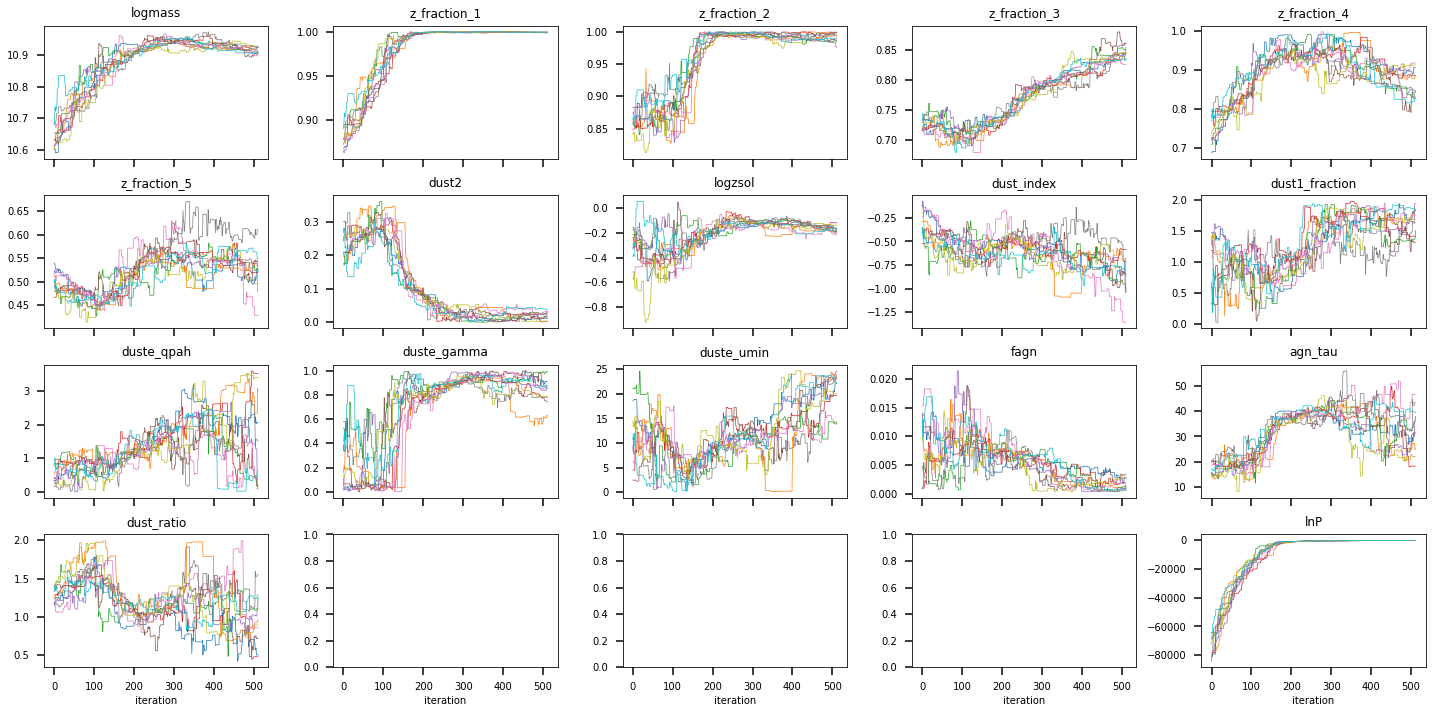

In [35]:
### Plotting Parameter Traces ###
chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)

savefig(Galaxy_Path + 'G{0}_{1}_{2}_param_trace_4'.format(galaxy_num, Template_Type, ts))

Optimization value: [ 1.00000000e+01  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  3.00000000e-01 -5.00000000e-01
  0.00000000e+00  1.00000000e+00  3.00000000e+00  1.00000000e-02
  1.00000000e+00  1.00000000e-04  5.00000000e+00  1.00000000e+00]
MAP value: [ 1.09232059e+01  9.99395319e-01  9.95420973e-01  8.57066214e-01
  8.49134781e-01  5.74566651e-01  5.04633342e-03 -1.57209802e-01
 -4.22288054e-01  1.09999983e+00  3.39532510e+00  7.83270730e-01
  2.31052878e+01  1.56529613e-03  1.82412072e+01  8.67049291e-01]


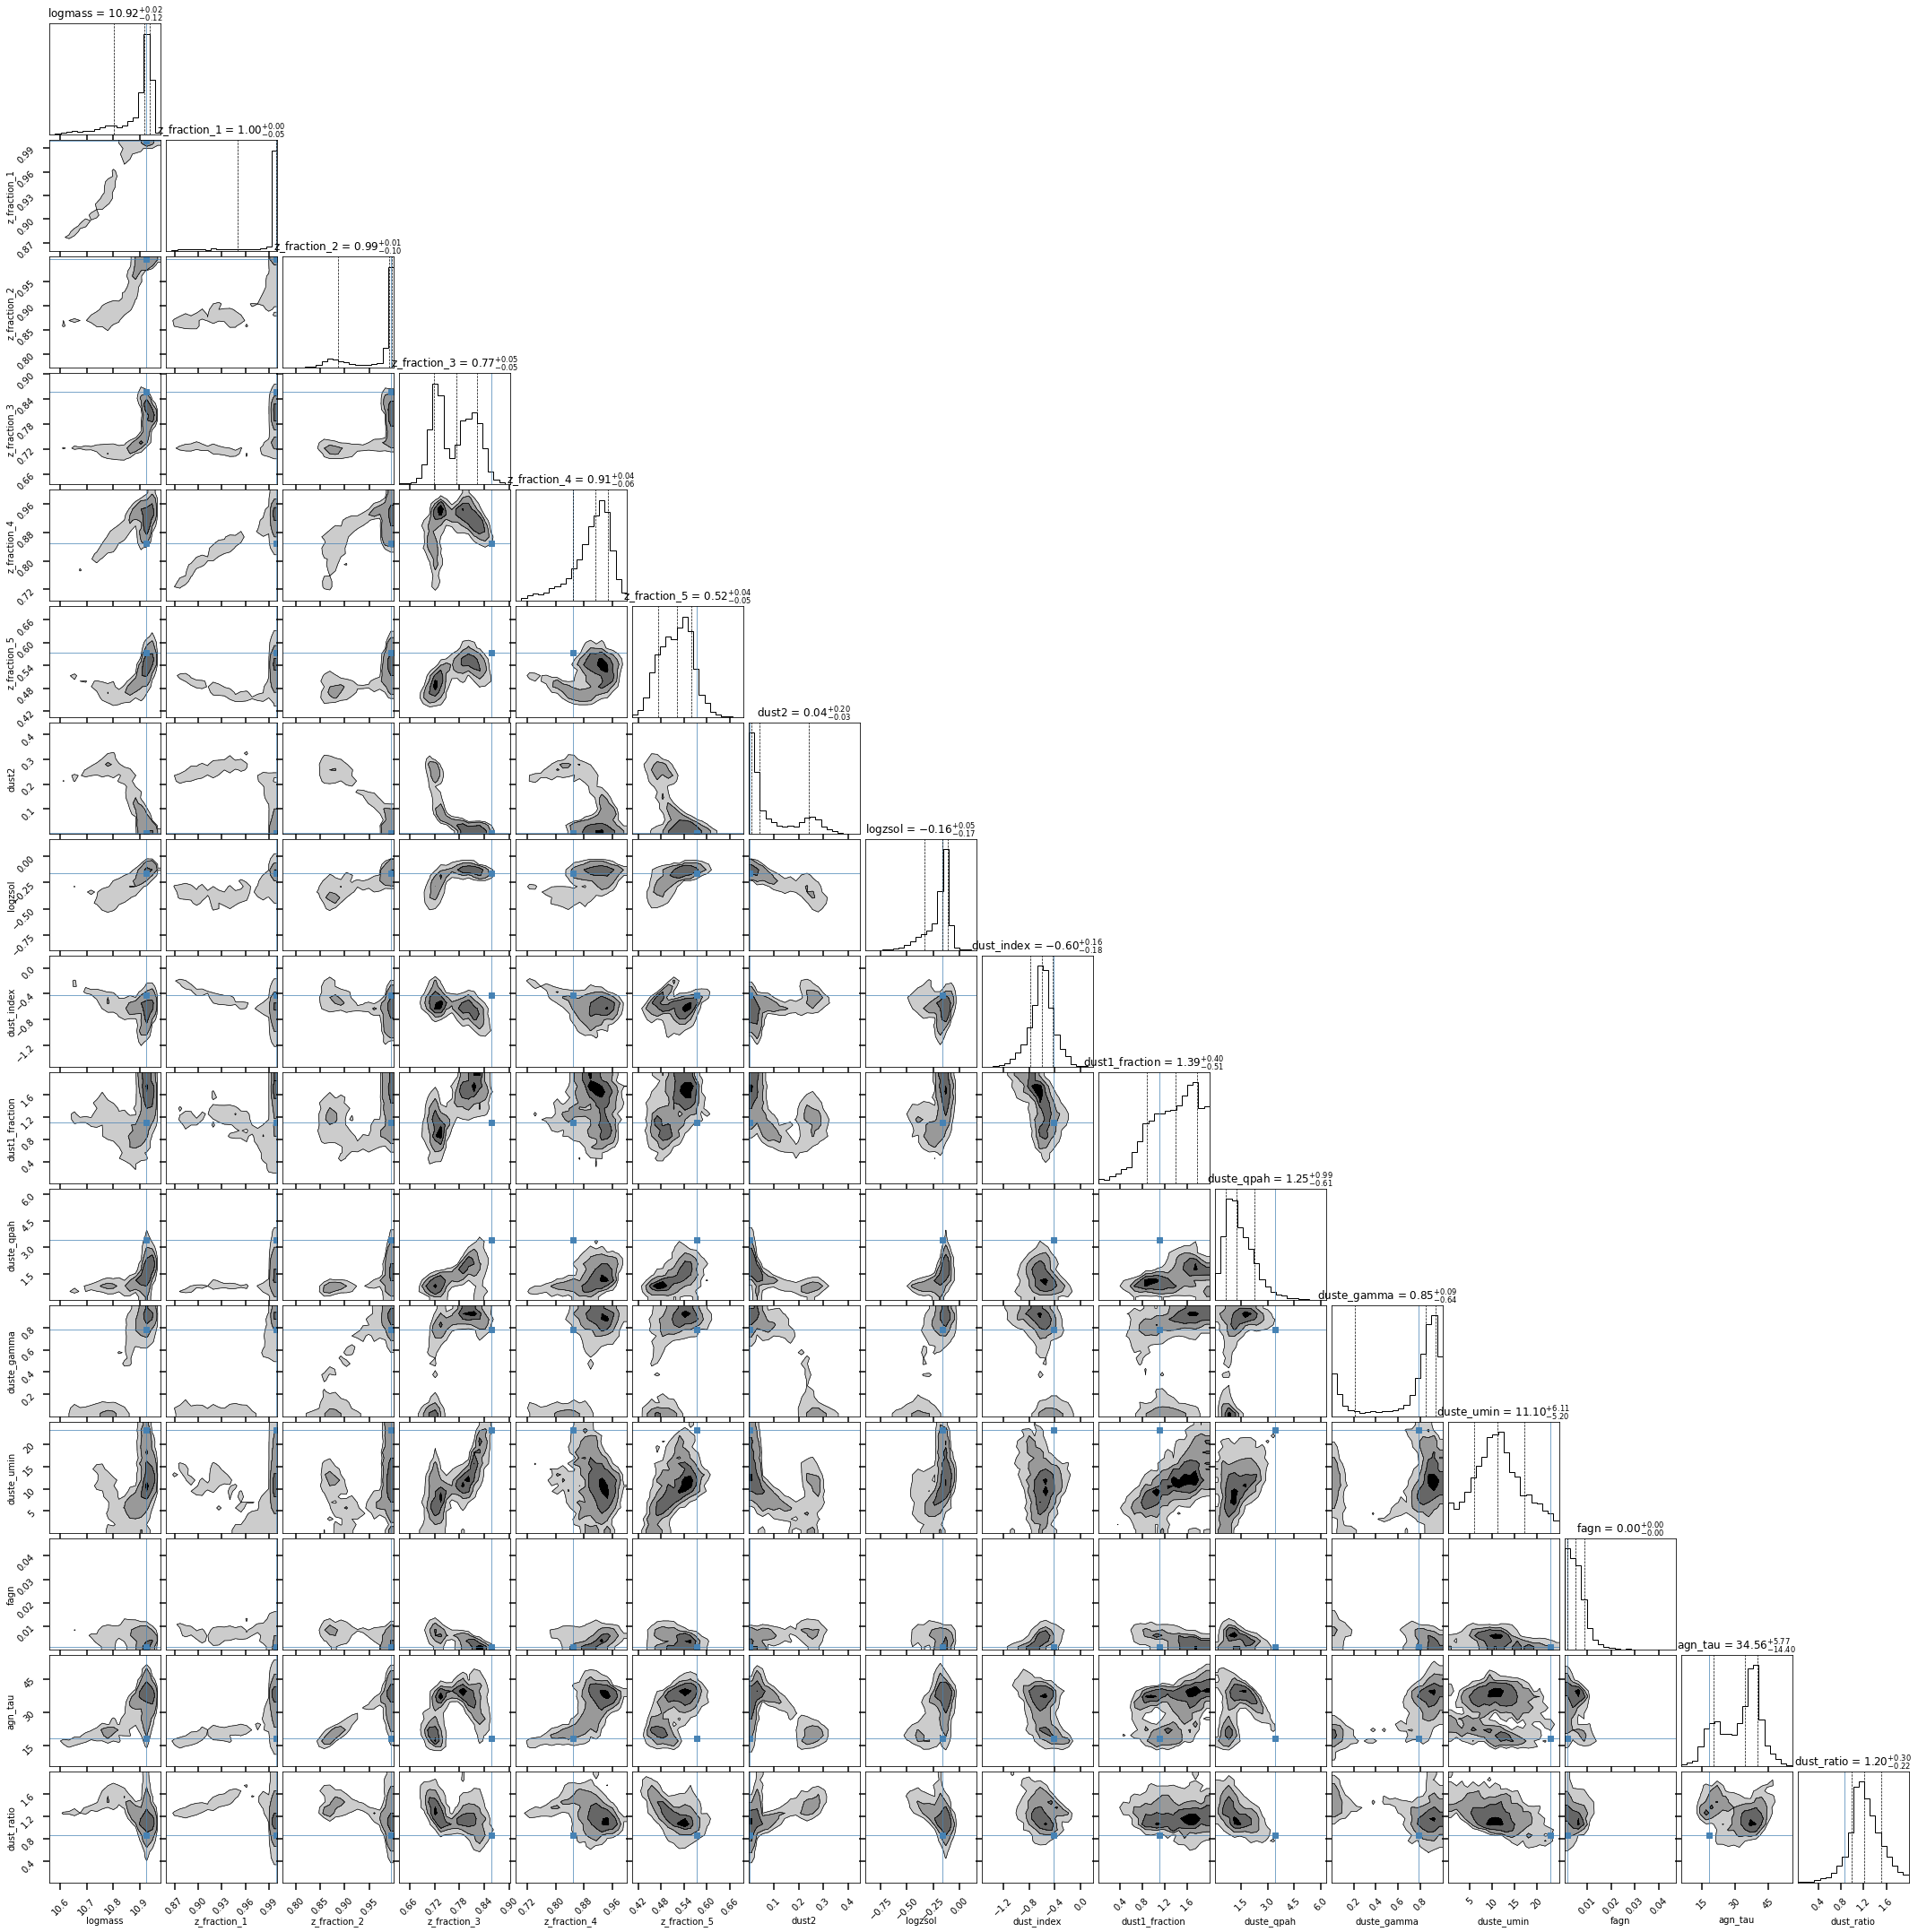

In [37]:
### Corner Plot ###
# maximum a posterior (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
i, j = np.unravel_index(imax, result['lnprobability'].shape)
theta_max = result['chain'][i, j, :].copy()
thin = 5

# if is_free_params < mask_len_array or is_free_params != mask_len_array:
print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))


# if is_free_params < mask_len_array or is_free_params != mask_len_array:
cornerfig = reader.subcorner(result, start=0, thin=thin, truths= result['bestfit']['parameter'],  
                             fig=subplots(16,16,figsize=(30,30))[0])       # MUST modify subplot, 
# else:
#     cornerfig = reader.subcorner(result, start=0, thin=thin,   
#                              fig=subplots(17,17,figsize=(30,30))[0])       # MUST modify subplot, 

savefig(Galaxy_Path + 'G{0}_{1}_{2}_corner_plot_5'.format(galaxy_num, Template_Type, ts))

In [50]:
import pandas
pandas.DataFrame([theta_best, result['bestfit']['parameter']], index=['theta_best', 'bestfit'], columns=result['theta_labels']).T

theta_best    bestfit
logmass          10.000000  10.923206
z_fraction_1      0.833333   0.999395
z_fraction_2      0.800000   0.995421
z_fraction_3      0.750000   0.857066
z_fraction_4      0.666667   0.849135
z_fraction_5      0.500000   0.574567
dust2             0.300000   0.005046
logzsol          -0.500000  -0.157210
dust_index        0.000000  -0.422288
dust1_fraction    1.000000   1.100000
duste_qpah        3.000000   3.395325
duste_gamma       0.010000   0.783271
duste_umin        1.000000  23.105288
fagn              0.000100   0.001565
agn_tau           5.000000  18.241207
dust_ratio        1.000000   0.867049

In [39]:
# https://github.com/nolaaa/SED_fitting_Prospecotr/blob/master/7_run_prospector_for_all_arcs.ipynb

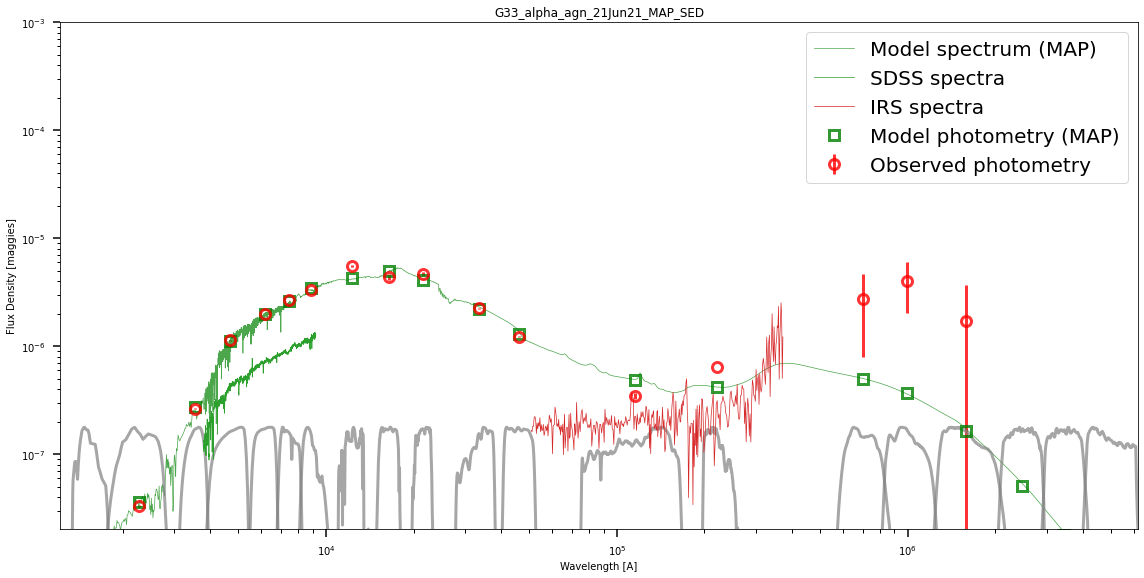

In [40]:
# https://github.com/bd-j/prospector/issues/186

mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec * (1 + model.params['zred']), mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Plot optical and IRS data if available
plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra')
if IRS_indicator == 1:
    plot(IRS_wavelength, IRS_flux, label='IRS spectra')

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()
title('G{0}_{1}_{2}_MAP_SED'.format(galaxy_num, Template_Type, ts))

savefig(Galaxy_Path + 'G{0}_{1}_{2}_MAP_SED_6'.format(galaxy_num, Template_Type, ts))

In [41]:
end_time = time.time()
print("this program takes:", end_time - start_time, "seconds to run")
print("this program takes:", (end_time - start_time)/60, "minutes to run")

this program takes: 3015.802802801132 seconds to run
this program takes: 50.26338004668553 minutes to run


In [42]:
result['bestfit'] #https://github.com/bd-j/prospector/issues/215

{'parameter': array([ 1.09232059e+01,  9.99395319e-01,  9.95420973e-01,  8.57066214e-01,
         8.49134781e-01,  5.74566651e-01,  5.04633342e-03, -1.57209802e-01,
        -4.22288054e-01,  1.09999983e+00,  3.39532510e+00,  7.83270730e-01,
         2.31052878e+01,  1.56529613e-03,  1.82412072e+01,  8.67049291e-01]),
 'photometry': array([1.08697019e-08, 3.60156023e-08, 2.71855664e-07, 1.12048066e-06,
        2.00388069e-06, 2.62849565e-06, 3.45316554e-06, 2.22065379e-06,
        1.28482510e-06, 4.83601164e-07, 4.22878981e-07, 4.91782786e-07,
        3.70052303e-07, 1.62974605e-07, 5.11105821e-08, 1.76760094e-08,
        5.77736307e-09, 5.02119089e-06, 4.25633403e-06, 4.08639722e-06]),
 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 'spectrum': array([4.78024832e-72, 4.78024832e-72, 4.78024832e-72, ...,
        3.85567147e-10, 3.85812911e-10, 3.86599298e-10]),
 'mfrac': 0.5836053591931695}